In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from functools import lru_cache, reduce
from scipy import ndimage
from mpl_toolkits.mplot3d import Axes3D
import collections

In [0]:
%tensorflow_version

Currently selected TF version: 1.x
Available versions:
* 1.x
* 2.x


In [0]:
# ran in colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# load files into arrays
fashion_train_array = np.load('/content/drive/My Drive/zalando_all/fashion_train.npy') # 10000,785
fashion_test_array = np.load('/content/drive/My Drive/zalando_all/fashion_test.npy') # 5000, 785
dilated_train_array = np.load('/content/drive/My Drive/zalando_all/dilated_input.npy') # 10000, 784
lda3_fashion_eigvecs = np.load('/content/drive/My Drive/zalando_all/sorted_eigvecs_3.npy')
lda4_fashion_eigvecs = np.load('/content/drive/My Drive/zalando_all/sorted_eigvecs_4.npy')

In [0]:
# take labels and features from train and test
fashion_train_features = fashion_train_array[:, :-1]
fashion_train_labels = fashion_train_array[:, -1]
fashion_test_features = fashion_test_array[:, :-1]
fashion_test_labels = fashion_test_array[:, -1]

In [0]:
fashion_train_array[:, -1]

array([0, 1, 0, ..., 3, 0, 1], dtype=uint8)

In [0]:
for label1, label2 in zip(fashion_train_array[:, -1], fashion_train_labels):
  print(f"{label1}\t{label2}")

0	0
1	1
0	0
3	3
4	4
1	1
2	2
2	2
2	2
1	1
3	3
4	4
3	3
1	1
0	0
3	3
1	1
2	2
0	0
4	4
0	0
0	0
3	3
1	1
4	4
0	0
3	3
3	3
4	4
3	3
4	4
3	3
1	1
1	1
2	2
3	3
4	4
2	2
3	3
3	3
0	0
3	3
1	1
3	3
0	0
1	1
1	1
2	2
4	4
0	0
4	4
4	4
3	3
4	4
3	3
0	0
4	4
2	2
3	3
4	4
3	3
4	4
3	3
1	1
2	2
4	4
2	2
2	2
3	3
2	2
3	3
2	2
4	4
3	3
1	1
4	4
3	3
0	0
1	1
0	0
0	0
0	0
3	3
4	4
1	1
3	3
3	3
2	2
4	4
0	0
1	1
2	2
4	4
4	4
1	1
0	0
4	4
1	1
1	1
1	1
0	0
3	3
2	2
2	2
4	4
0	0
2	2
1	1
0	0
1	1
4	4
1	1
4	4
1	1
4	4
3	3
2	2
1	1
0	0
4	4
3	3
4	4
0	0
1	1
4	4
2	2
2	2
3	3
2	2
4	4
1	1
1	1
1	1
4	4
2	2
0	0
3	3
4	4
2	2
4	4
3	3
3	3
3	3
4	4
0	0
0	0
3	3
3	3
1	1
1	1
4	4
4	4
1	1
2	2
4	4
0	0
2	2
0	0
1	1
4	4
2	2
2	2
1	1
2	2
4	4
1	1
4	4
3	3
4	4
2	2
4	4
0	0
1	1
3	3
2	2
2	2
1	1
0	0
4	4
0	0
0	0
2	2
0	0
2	2
0	0
2	2
2	2
1	1
4	4
4	4
0	0
0	0
4	4
3	3
1	1
2	2
0	0
1	1
1	1
3	3
4	4
4	4
4	4
1	1
2	2
4	4
2	2
1	1
4	4
4	4
1	1
4	4
1	1
4	4
2	2
2	2
3	3
1	1
3	3
3	3
3	3
3	3
2	2
3	3
4	4
3	3
3	3
2	2
4	4
4	4
0	0
3	3
2	2
1	1
3	3
4	4
2	2
1	1
0	0
2	2
4	4
3	3
4	4
2	2
2	2
4	4
1	1
2	2
2	2
1	1


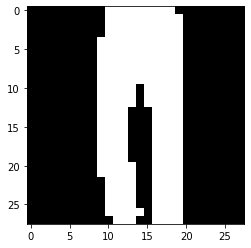

In [0]:
#  just for check
plt.imshow(dilated_train_array[1,:].reshape(28,28), cmap = 'gray')

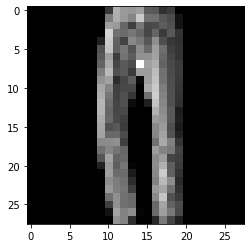

In [0]:
# just for check
plt.imshow(fashion_train_features[1,:].reshape(28,28), cmap = 'gray')

In [0]:
# function for dlation process
def dilating_784_sized_picture_array(pic_array):
  dilated_array = np.zeros_like(pic_array)
  for idx, pict in enumerate(pic_array):
    reshaped_pict = pict.reshape(28,28)
    bin_picture = np.zeros((28,28), dtype = np.int8)
    bin_picture[reshaped_pict > 0] = 255
    open_picture = ndimage.binary_opening(bin_picture)
    eroded_picture = ndimage.binary_erosion(bin_picture)
    prop_picture = ndimage.binary_propagation(eroded_picture, mask = bin_picture)
    dilated_array[idx] = prop_picture.reshape(784,)
  return dilated_array

In [0]:
# creating dilated final test
dilated_test_array = dilating_784_sized_picture_array(fashion_test_features)

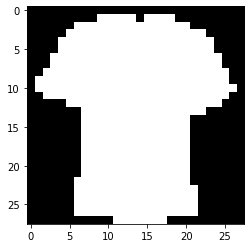

In [0]:
# just for check
plt.imshow(dilated_test_array[1, :].reshape(28,28), cmap = 'gray')

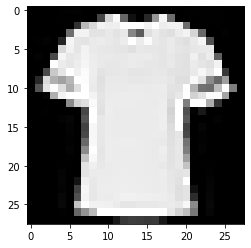

In [0]:
# just for check
plt.imshow(fashion_test_features[1, :].reshape(28,28), cmap = 'gray')

In [0]:
# normalizing input
fashion_train_features = fashion_train_features / np.max(fashion_train_features)
np.max(fashion_train_features)

1.0

In [0]:
def lda(features, labels):
  # calculating linear components
  get_class = lambda i: np.take(features, np.argwhere(labels == i), axis = 0)
  classes = np.array([get_class(i) for i in set(labels)])

  mean = lambda c: np.mean(c, axis = 0)
  prod = lambda x, m: np.outer((x - m), (x - m))
  get_si = lambda c: reduce(lambda mat, x: mat + prod(x, mean(c)), c, np.zeros((784,784)))

  within_scat = np.sum([get_si(c) for c in classes], axis = 0)
  between_scat = np.sum([len(c)*prod(mean(c), mean(features)) for c in classes], axis = 0)

  eig_vals, eig_vecs = np.linalg.eig(np.dot(np.linalg.inv(within_scat), between_scat))
  sorted_eig_vecs = eig_vecs[:, eig_vals.argsort()[::-1]].real

  eig_vals = eig_vals.real / np.sum(eig_vals.real)
  print(np.sort(eig_vals)[::-1][:5])


  return sorted_eig_vecs

In [0]:
# lda eigvector calculations for normalized and dilated datasets
eig_vecs_norm = lda(fashion_train_features, fashion_train_labels)
eig_vecs_dil = lda(dilated_train_array, fashion_train_labels)

[6.11131782e-01 2.02405516e-01 1.31287448e-01 5.51752545e-02
 7.94989352e-15]
[6.15982521e-01 1.94057222e-01 1.38942061e-01 5.10181955e-02
 4.32611545e-15]


In [0]:
# pick vectors for normalized dataset
lda3_eigvecs_norm = eig_vecs_norm[:, :3]
lda4_eigvecs_norm = eig_vecs_norm[:, :4]

# dilated dataset
lda3_eigvecs_dil = eig_vecs_dil[:, :3]
lda4_eigvecs_dil = eig_vecs_dil[:, :4]

# readin_eigvcs

In [0]:
# projections for normalized dataset
projections3_norm = np.dot(fashion_train_features, lda3_eigvecs_norm)
projections4_norm = np.dot(fashion_train_features, lda4_eigvecs_norm)

# for dilated
projections3_dil = np.dot(dilated_train_array, lda3_eigvecs_dil)
projections4_dil = np.dot(dilated_train_array, lda4_eigvecs_dil)

# readin eigvecs
r_eigvecs3_pro_norm = np.dot(fashion_train_features, lda3_fashion_eigvecs)
r_eigvecs4_pro_norm = np.dot(fashion_train_features, lda4_fashion_eigvecs)

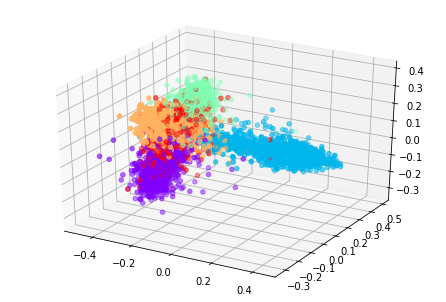

In [0]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(projections3_dil[:, 0], projections3_dil[:, 1], projections3_dil[:, 2], c = fashion_train_labels, cmap = 'rainbow')

In [0]:
# pca function
def pca(features):
  mean = sum(features) / features.shape[0]
  X = np.array([features[:, i] - mean[i] for i in range(features.shape[1])]).T
  C = np.matmul(np.transpose(X), X) / features.shape[1]

  eig_vals, eig_vecs = np.linalg.eig(C)
  return eig_vecs[:, eig_vals.argsort()[::-1]].real

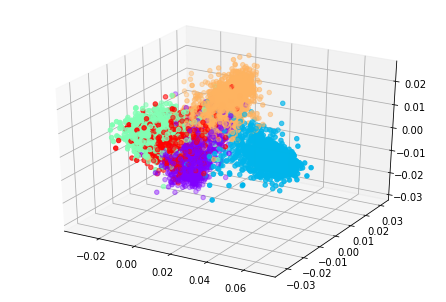

In [0]:
lda3_pca_norm_eigvecs = pca(projections3_norm)
projection = np.dot(projections3_norm, lda3_pca_norm_eigvecs)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(projections3_norm[:, 0], projections3_norm[:, 1], projections3_norm[:, 2], c = fashion_train_labels, cmap = 'rainbow')

In [0]:
# to run tests with random validation sets
def build_random_train_test(features, labels):
  # build random index and split dataset
  rand_index = np.arange(features.shape[0])
  np.random.shuffle(rand_index)
  features = features[rand_index]
  labels = labels[rand_index]
  divider = int(features.shape[0] * 0.8)
  feature_train = features[:divider]
  feature_test =  features[divider:]
  label_train = labels[:divider]
  label_test = labels[divider:]
  return feature_train, label_train, feature_test, label_test

In [0]:
f_tr, l_tr, f_te, l_te = build_random_train_test(fashion_train_array, fashion_train_labels)
f_tr[:, -1], l_tr

(array([3, 4, 0, ..., 2, 4, 2], dtype=uint8),
 array([3, 4, 0, ..., 2, 4, 2], dtype=uint8))

In [0]:
fashion_train_array[:, -1], fashion_train_labels

(array([0, 1, 0, ..., 3, 0, 1], dtype=uint8),
 array([0, 1, 0, ..., 3, 0, 1], dtype=uint8))

In [0]:
def kmeans_classifier(f_train, l_train, f_test, l_test):
  predicted_labels = np.zeros_like(l_test)
  means = [np.mean(f_train[l_train == i], axis = 0) for i in range(5)]
  #print(means)
  accurate = 0
  result_matrix = np.zeros((5,5))
  for idx, row in enumerate(f_test):
    distances = np.array([np.linalg.norm(row - this_mean) for this_mean in means])
    result_matrix[l_test[idx], distances.argmin()] += 1
    if (distances.argmin() == l_test[idx]):
      accurate += 1
    predicted_labels[idx] = distances.argmin()
  print(result_matrix)
  print(accurate / l_test.shape[0])
  return l_test, predicted_labels

In [0]:
def knearest_neighbor(f_train, l_train, f_test, l_test, k = 3):
  predicted_labels = np.zeros_like(l_test)
  accurate = 0
  result_matrix = np.zeros((5,5))

  for idx, row in enumerate(f_test):
    current_distances = np.empty_like(l_train, dtype = np.float32)
    for idx_2, train_row in enumerate(f_train):
      current_distances[idx_2] = np.linalg.norm(row - train_row)
    
    closest_indices = np.argsort(current_distances)
    
    # decide on label
    a = collections.Counter(l_train[closest_indices[:k]])
    if len(a.most_common()) == 1:
      predicted = a.most_common()[0][0]
    elif a.most_common()[0][1] > a.most_common()[1][1]:
      predicted = a.most_common()[0][0]
    else:
      predicted = l_train[closest_indices[0]]
    result_matrix[l_test[idx], predicted] += 1
    if l_test[idx] == predicted:
      accurate += 1
    predicted_labels[idx] = predicted

  print(result_matrix)
  print(accurate / l_test.shape[0])

  return l_test, predicted_labels

In [0]:
f_train, l_train, f_test, l_test = build_random_train_test(dilated_train_array, fashion_train_labels)
t, p = knearest_neighbor(f_train, l_train, f_test, l_test, 5)

[[354.   1.   6.   8.  42.]
 [  0. 383.   1.   9.   3.]
 [  5.   0. 359.   8.  50.]
 [ 16.   7.   2. 362.  10.]
 [ 70.   0.  55.  20. 229.]]
0.8435
